In [2]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.models import Model

def VGG16_with_CBAM(input_shape):
    # Load the pre-trained VGG16 model with weights from ImageNet
    vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Add your CBAM layers here
    def cbam_block(cbam_feature, ratio=8):
        cbam_feature = channel_attention(cbam_feature, ratio)
        return cbam_feature

    def channel_attention(input_feature, ratio=8):
        channel_axis = 1 if tf.keras.backend.image_data_format() == "channels_first" else -1
        channel = input_feature.shape[channel_axis]

        shared_layer_one = Dense(channel//ratio,
                                activation='relu',
                                kernel_initializer='he_normal',
                                use_bias=True,
                                bias_initializer='zeros')
        shared_layer_two = Dense(channel,
                                kernel_initializer='he_normal',
                                use_bias=True,
                                bias_initializer='zeros')

        avg_pool = tf.keras.layers.GlobalAveragePooling2D()(input_feature)
        avg_pool = tf.keras.layers.Reshape((1, 1, channel))(avg_pool)
        assert avg_pool.shape[1:] == (1, 1, channel)
        avg_pool = shared_layer_one(avg_pool)
        assert avg_pool.shape[1:] == (1, 1, channel//ratio)
        avg_pool = shared_layer_two(avg_pool)
        assert avg_pool.shape[1:] == (1, 1, channel)

        max_pool = tf.keras.layers.GlobalMaxPooling2D()(input_feature)
        max_pool = tf.keras.layers.Reshape((1, 1, channel))(max_pool)
        assert max_pool.shape[1:] == (1, 1, channel)
        max_pool = shared_layer_one(max_pool)
        assert max_pool.shape[1:] == (1, 1, channel//ratio)
        max_pool = shared_layer_two(max_pool)
        assert max_pool.shape[1:] == (1, 1, channel)

        cbam_feature = tf.keras.layers.Add()([avg_pool, max_pool])
        cbam_feature = tf.keras.layers.Activation('sigmoid')(cbam_feature)

        if tf.keras.backend.image_data_format() == "channels_first":
            cbam_feature = tf.keras.layers.Permute((3, 1, 2))(cbam_feature)

        return tf.keras.layers.Multiply()([input_feature, cbam_feature])

    # Add the CBAM block to your VGG16 model
    vgg16_output = vgg16_model.layers[-1].output  # Getting the last layer of VGG16
    x = cbam_block(vgg16_output)  # Add CBAM after the last layer of VGG16

    # Customize the output layers as needed
    x = Flatten(name='flatten')(x)
    x = Dense(4096, activation='relu', name='fc1')(x)
    x = Dense(4096, activation='relu', name='fc2')(x)
    x = Dense(10, activation='softmax', name='predictions')(x)  

    # Create the model
    model = Model(inputs=vgg16_model.input, outputs=x, name='vgg16_with_cbam')

    return model

input_shape = (224, 224, 3)  # Adjust the input shape as needed
model = VGG16_with_CBAM(input_shape)

# Load weights from the pre-trained VGG16 model
vgg16_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

# Copy weights layer by layer
for layer, vgg_layer in zip(model.layers[2:], vgg16_model.layers[2:]):
    layer.set_weights(vgg_layer.get_weights())


1/1 [==============================] - 0s 344ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


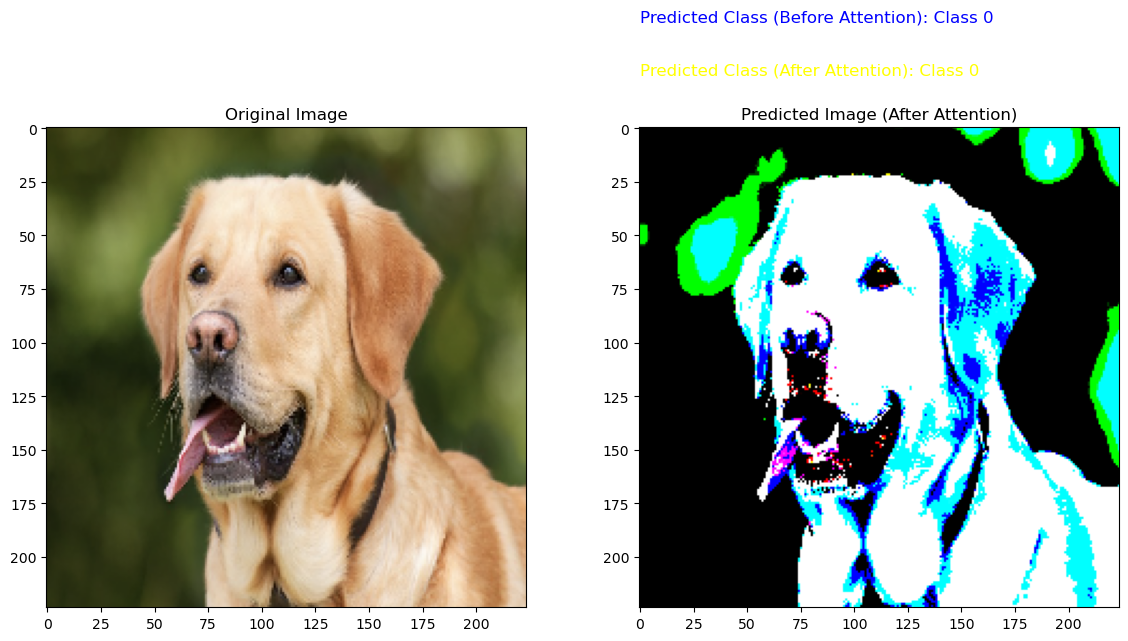

In [3]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt

# Load an example image for testing
img_path = '/Users/sandeepreddy/Desktop/Dogs/jer.jpeg'  
img = image.load_img(img_path, target_size=(224, 224))  
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  
img_array = preprocess_input(img_array)  

# Perform inference on the loaded image
classification_results_before_attention = model.predict(img_array)

# Create a model with CBAM
model = VGG16_with_CBAM(input_shape=(224, 224, 3))

# Perform inference with CBAM
classification_results_after_attention = model.predict(img_array)


# Get the class labels
class_labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6', 'Class 7', 'Class 8', 'Class 9']

# Visualize the original and predicted images side by side
plt.figure(figsize=(12, 6))

# Original Image
plt.subplot(1, 2, 1)
plt.imshow(img)
plt.title('Original Image')

# Predicted Image
plt.subplot(1, 2, 2)

# Display the images
plt.imshow(img_array[0])
plt.title('Predicted Image (After Attention)')

# Display the predicted class labels for both results
predicted_class_before = class_labels[np.argmax(classification_results_before_attention)]
predicted_class_after = class_labels[np.argmax(classification_results_after_attention)]

# Add text labels
plt.text(0, -50, f'Predicted Class (Before Attention): {predicted_class_before}', fontsize=12, color='blue')
plt.text(0, -25, f'Predicted Class (After Attention): {predicted_class_after}', fontsize=12, color='yellow')

plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 160ms/step
Classification Results Before Attention:
[[1.8405813e-01 2.0815273e-08 7.9827023e-01 1.3086545e-09 6.7592971e-04
  1.6963208e-02 1.2692768e-10 4.9588771e-06 4.6032042e-06 2.2985838e-05]]
1/1 [==============================] - 0s 355ms/step
Classification Results After Attention:
[[3.9284257e-17 2.0725536e-05 1.0042432e-02 9.4624603e-01 4.3685634e-02
  2.8238803e-06 2.4505701e-13 4.8445358e-08 3.1928732e-10 2.3470475e-06]]
1/1 [==============================] - 0s 127ms/step


<Figure size 800x800 with 0 Axes>

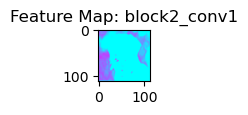

<Figure size 800x800 with 0 Axes>

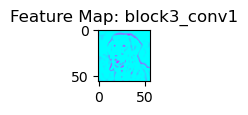

<Figure size 800x800 with 0 Axes>

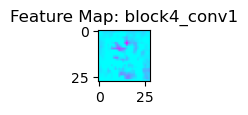

In [13]:
img_path = '/Users/sandeepreddy/Desktop/Dogs/jer.jpeg' 
img = image.load_img(img_path, target_size=(224, 224))  
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  
img_array = preprocess_input(img_array) 

# Perform inference on the loaded image
classification_results_before_attention = model.predict(img_array)

# Visualize the classification results before attention
print("Classification Results Before Attention:")
print(classification_results_before_attention)

# After attention
model = VGG16_with_CBAM(input_shape=(224, 224, 3))
classification_results_after_attention = model.predict(img_array)

# Visualize the classification results after attention
print("Classification Results After Attention:")
print(classification_results_after_attention)

# Create a new model to extract feature maps after attention modules
layer_names = ['block2_conv1', 'block3_conv1', 'block4_conv1']  # Specifiying each layer to visualize
feature_map_model = Model(inputs=model.input, outputs=[model.get_layer(name).output for name in layer_names])

# Get feature maps for the input image
feature_maps = feature_map_model.predict(img_array)

# Visualize the feature maps
for i, layer_name in enumerate(layer_names):
    feature_map = feature_maps[i][0]  # Choosing the first sample in the batch
    plt.figure(figsize=(8, 8))
#     plt.imshow(feature_map[:, :, 0], cmap='viridis')  # You can choose a different channel or colormap
    plt.figure(figsize=(120 / 180, 120 / 180))
    plt.imshow(feature_map[:, :, 0], cmap='cool')
    plt.title(f'Feature Map: {layer_name}')
    plt.show()

As we can see the attention model after each layer changes from Convol_layer1, convo_layer2 and Convol_layer3.

The results after before the classification layer are : 7.4620363e-09 2.6368647e-04 1.3149059e-13 4.0619591e-11 9.9973541e-01
  8.1667569e-14 3.2210129e-14 5.4828325e-07 2.7453839e-07 5.5835482e-11.
  
These values says the results after before the classification layer," seems to represent the output of your model before the final classification layer.

The results after the classification layer are: [4.6550786e-01 2.2719584e-01 1.5418485e-05 2.6086405e-01 1.1002885e-08
  8.5205464e-03 1.5892963e-03 3.6305204e-02 1.7704231e-06 4.9853966e-08.
  
These values says the  results after the classification layer," appears to represent the output of your model after passing through the final classification layer.

After each and every block of the convolution layer the image is more clealy optained at the last convolutonal layer. When we see in Block4_conv1  the image is so blured, when compared to Block3_conv1, and when we compare the Block3_conv1 with Block2_conv1, the image is more clealy optianed in Block2_conv1. 